In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import scipy
from sklearn.preprocessing import OrdinalEncoder
from yellowbrick.regressor import CooksDistance , ResidualsPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
%matplotlib inline

<font size=4> Getting the train and test data</font>

In [2]:
train = pd.read_csv("D:/IPBA/Statistical Modelling/Linear Regression/Kaggle Comp/train2.csv")
test = pd.read_csv("D:/IPBA/Statistical Modelling/Linear Regression/Kaggle Comp/test2.csv")
print(train.shape)
print(test.shape)

(4809, 14)
(1210, 13)


Combining the train and test dataframes in order to perform the analysis and data manipulation

In [3]:
tt = pd.concat((train , test) , axis=0)
tt.shape

(6019, 14)

<font size = 5>EDA and Data Manipulation</font>

In [4]:
tt.head()

,id,Name,Year,Kilometers_Driven,Location,Fuel_Type,Transmission,Engine,Power,Mileage,Seats,Owner_Type,New_Price,Price
0,1,Hyundai Verna 1.6 SX,2017,65593,Ahmedabad,Diesel,Manual,1582 CC,126.32 bhp,22.32 kmpl,5.0,First,NaN,12.77
1,2,Hyundai i10 Era,2012,66095,Ahmedabad,Petrol,Manual,1086 CC,68.05 bhp,19.81 kmpl,5.0,Second,NaN,5.09
2,3,Volkswagen Polo Petrol Comfortline 1.2L,2017,64961,Jaipur,Petrol,Manual,1198 CC,73.9 bhp,16.47 kmpl,5.0,Second,NaN,10.05
3,4,Maruti Wagon R LXI,2009,55361,Ahmedabad,Petrol,Manual,998 CC,67.1 bhp,18.9 kmpl,5.0,Second,NaN,3.76
4,5,Maruti Ritz ZXi,2017,58294,Mumbai,Petrol,Manual,1197 CC,85.80 bhp,18.5 kmpl,5.0,First,NaN,7.26


In [5]:
tt.dtypes

id                     int64
Name                  object
Year                   int64
Kilometers_Driven      int64
Location              object
Fuel_Type             object
Transmission          object
Engine                object
Power                 object
Mileage               object
Seats                float64
Owner_Type            object
New_Price             object
Price                float64
dtype: object

In [6]:
tt.isnull().sum()

id                      0
Name                    0
Year                    0
Kilometers_Driven       0
Location                0
Fuel_Type               0
Transmission            0
Engine                 36
Power                  36
Mileage                 2
Seats                  42
Owner_Type              0
New_Price            5195
Price                1210
dtype: int64

<font color="Maroon">Data Types</font><br>
The data types for the variables Engine , Mileage and Power are object because the values contain units as well . Need to convert these to floats for better analysis.<br>
Convert the data type of all the categorical variables to 'Category' for better performance.<br>
<font color="Maroon">Null Values</font><br>
The variable New_Price has 5195 null values out of 6019 total values . Imputing this will not be helpful , hence , dropping the variable. <br>
The target price has 1210 null values which are from the test data.<br>
Need to impute the null values in the rest of the variables (Engine , Power ,Seats , Mileage)

<font size=4>Univariate/Multivariate Analysis and variable transformation and cleaning</font> <br>
Analysing the variables, imputing the null values , creating new variables using the given set and changing the data types.

In [7]:
#Dropping New_Price
df = tt.drop('New_Price' , axis=1)
df.head()

,id,Name,Year,Kilometers_Driven,Location,Fuel_Type,Transmission,Engine,Power,Mileage,Seats,Owner_Type,Price
0,1,Hyundai Verna 1.6 SX,2017,65593,Ahmedabad,Diesel,Manual,1582 CC,126.32 bhp,22.32 kmpl,5.0,First,12.77
1,2,Hyundai i10 Era,2012,66095,Ahmedabad,Petrol,Manual,1086 CC,68.05 bhp,19.81 kmpl,5.0,Second,5.09
2,3,Volkswagen Polo Petrol Comfortline 1.2L,2017,64961,Jaipur,Petrol,Manual,1198 CC,73.9 bhp,16.47 kmpl,5.0,Second,10.05
3,4,Maruti Wagon R LXI,2009,55361,Ahmedabad,Petrol,Manual,998 CC,67.1 bhp,18.9 kmpl,5.0,Second,3.76
4,5,Maruti Ritz ZXi,2017,58294,Mumbai,Petrol,Manual,1197 CC,85.80 bhp,18.5 kmpl,5.0,First,7.26


<font size=4>Name</font>

In [8]:
df['Name'].describe()

count                       6019
unique                      1876
top       Mahindra XUV500 W8 2WD
freq                          49
Name: Name, dtype: object

Name contains the Company name and the model name . <br>So converting these into two columns which can be used as two variables for the regression. <br>Dropping the name column.

In [9]:
df['Company']=df['Name'].str.split(expand=True)[0]
df['Model']=df['Name'].str.split(" " , n=1 , expand=True)[1]
df = df.drop('Name' , axis=1)
df.head()

,id,Year,Kilometers_Driven,Location,Fuel_Type,Transmission,Engine,Power,Mileage,Seats,Owner_Type,Price,Company,Model
0,1,2017,65593,Ahmedabad,Diesel,Manual,1582 CC,126.32 bhp,22.32 kmpl,5.0,First,12.77,Hyundai,Verna 1.6 SX
1,2,2012,66095,Ahmedabad,Petrol,Manual,1086 CC,68.05 bhp,19.81 kmpl,5.0,Second,5.09,Hyundai,i10 Era
2,3,2017,64961,Jaipur,Petrol,Manual,1198 CC,73.9 bhp,16.47 kmpl,5.0,Second,10.05,Volkswagen,Polo Petrol Comfortline 1.2L
3,4,2009,55361,Ahmedabad,Petrol,Manual,998 CC,67.1 bhp,18.9 kmpl,5.0,Second,3.76,Maruti,Wagon R LXI
4,5,2017,58294,Mumbai,Petrol,Manual,1197 CC,85.80 bhp,18.5 kmpl,5.0,First,7.26,Maruti,Ritz ZXi


<font size=4>Year</font>

In [10]:
df['Year'].value_counts()

2016    747
2017    707
2018    684
2015    614
2014    567
2019    565
2013    427
2020    366
2012    360
2011    248
2010    190
2021    165
2009    126
2008     95
2007     56
2006     45
2005     19
2004     14
2003     10
2002      8
2000      4
1999      2
Name: Year, dtype: int64

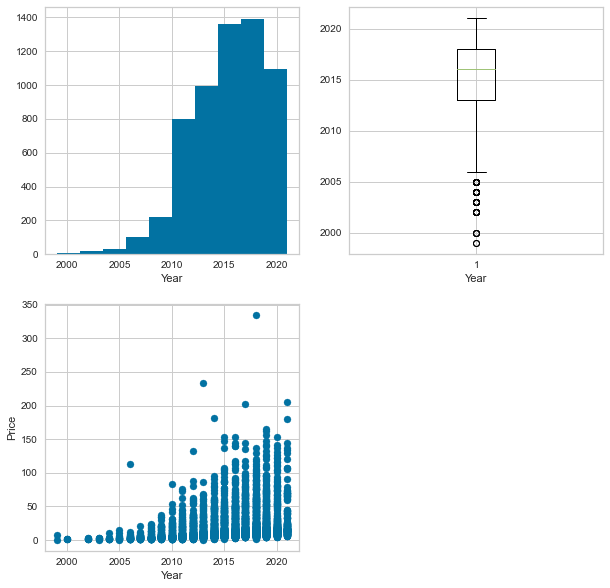

In [11]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist(df['Year'])
plt.xlabel('Year')
plt.subplot(2,2,2)
plt.boxplot(df['Year'] , whis=1.5)
plt.xlabel('Year')
plt.subplot(2,2,3)
plt.scatter(df['Year'] , df['Price'])
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

<font size=4>Kilometers Driven</font>

In [12]:
df['Kilometers_Driven'].describe()

count    6.019000e+03
mean     5.885789e+04
std      9.215306e+04
min      2.290000e+02
25%      3.396400e+04
50%      5.318300e+04
75%      7.332500e+04
max      6.565068e+06
Name: Kilometers_Driven, dtype: float64

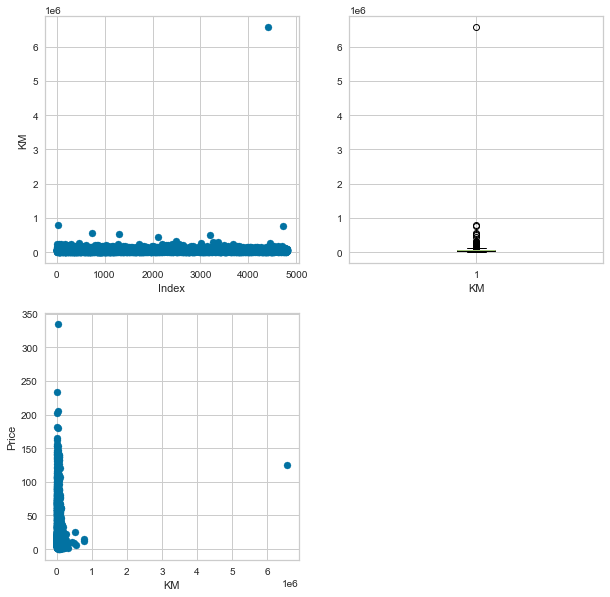

In [13]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(df['Kilometers_Driven'].index , df['Kilometers_Driven'])
plt.xlabel('Index')
plt.ylabel('KM')
plt.subplot(2,2,2)
plt.boxplot(df['Kilometers_Driven'] , whis=1.5)
plt.xlabel('KM')
plt.subplot(2,2,3)
plt.scatter(df['Kilometers_Driven'] , df['Price'])
plt.xlabel('KM')
plt.ylabel('Price')
plt.show()

<font size=4>Location</font>

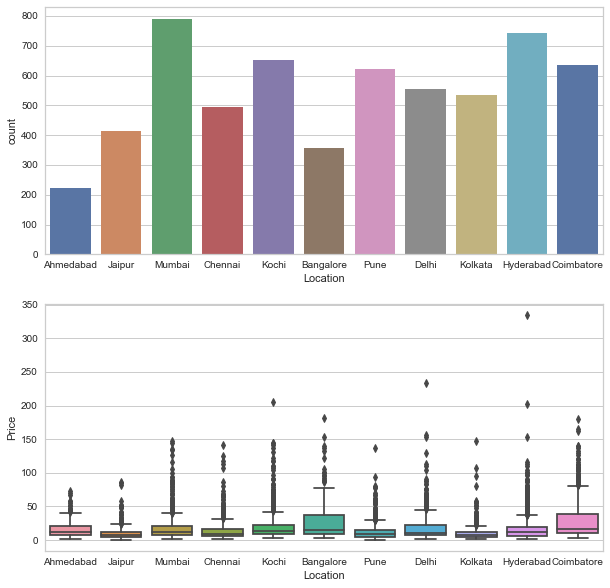

In [14]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.countplot(x = df['Location'] , palette='deep')
plt.subplot(2,1,2)
sns.boxplot(y=df['Price'] ,x= df['Location'] )
plt.show()

<font size=4>Fuel_Type</font>

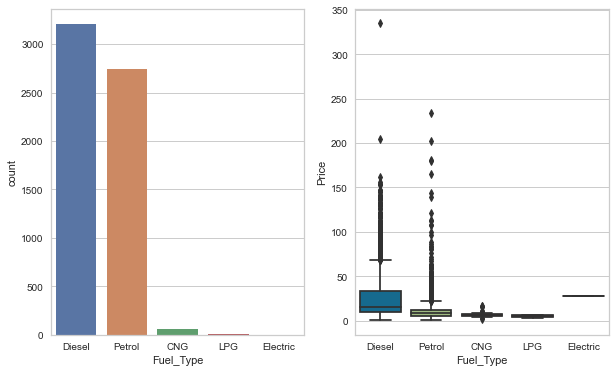

In [15]:
fig = plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.countplot(x = df['Fuel_Type'] , palette='deep')
plt.subplot(1,2,2)
sns.boxplot(y=df['Price'] ,x= df['Fuel_Type'] )
plt.show()

Converting Fuel_Type into numerical categories

<font size=4>Transmission</font>

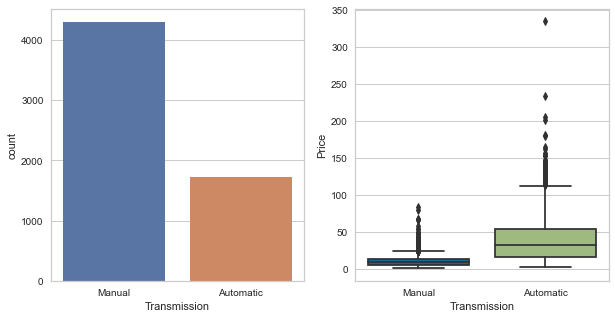

In [16]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(x = df['Transmission'] , palette='deep')
plt.subplot(1,2,2)
sns.boxplot(y=df['Price'] ,x= df['Transmission'] )
plt.show()

Converting Transmission into numrical Category

<font size=4>Engine</font>

In [17]:
df['Engine'].describe()

count        5983
unique        146
top       1197 CC
freq          606
Name: Engine, dtype: object

Removing the unit (CC) from Engine and converting it to float data type

In [18]:
df['Engine'] = df['Engine'].str.split(expand=True)[0].astype(float)
df['Engine'].describe()

count    5983.000000
mean     1621.276450
std       601.355233
min        72.000000
25%      1198.000000
50%      1493.000000
75%      1984.000000
max      5998.000000
Name: Engine, dtype: float64

Imputing missing values

In [19]:
imp = SimpleImputer(strategy='median')
imp.fit(df[['Engine']])
x = imp.transform(df[['Engine']])
df['Engine'] = pd.DataFrame(x , index=None)
df['Engine'].isnull().sum()

0

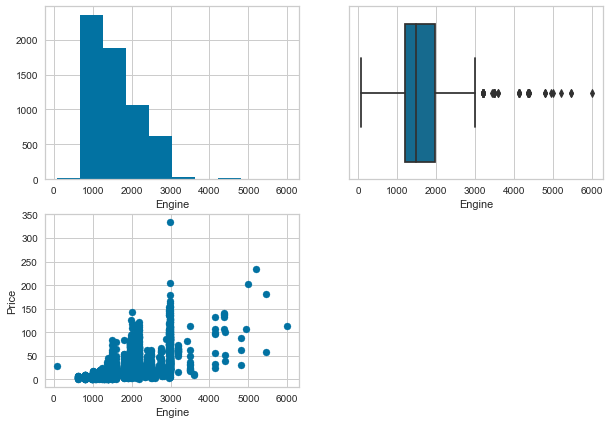

In [20]:
fig = plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
plt.hist(df['Engine'])
plt.xlabel('Engine')
plt.subplot(2,2,2)
sns.boxplot(x = 'Engine' , data=df)
plt.subplot(2,2,3)
plt.scatter(y=df['Price'] ,x= df['Engine'] )
plt.xlabel('Engine')
plt.ylabel('Price')
plt.show()

<font size=4>Power</font>

In [21]:
df['Power'].describe()

count       5983
unique       372
top       74 bhp
freq         235
Name: Power, dtype: object

There are "null" strings in the column. Changing those to the mode of the column

In [22]:
df['Power']=df['Power'].replace(r"null*" , df['Power'].mode()[0] , regex=True)

Removing bhp and converting power to float . 

In [23]:
df['Power'] = df['Power'].str.split(expand=True)[0].astype(float)
df['Power'].describe()

count    5983.000000
mean      112.551048
std        53.643837
min        34.200000
25%        74.000000
50%        92.700000
75%       138.100000
max       560.000000
Name: Power, dtype: float64

Handling missing values in Power

In [24]:
imp = SimpleImputer(strategy='mean')
imp.fit(df[['Power']])
x = imp.transform(df[['Power']])
df['Power'] = pd.DataFrame(x , index=None)
df['Power'].isnull().sum()

0

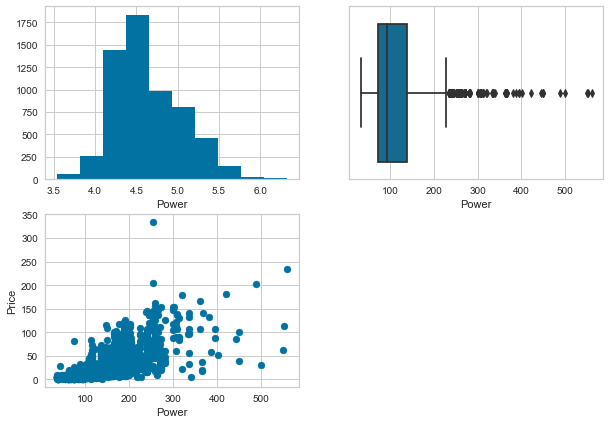

In [25]:
fig = plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
plt.hist(np.log(df['Power']))
plt.xlabel('Power')
plt.subplot(2,2,2)
sns.boxplot(x='Power' , data=df)
plt.subplot(2,2,3)
plt.scatter(y=df['Price'] ,x= df['Power'] )
plt.xlabel('Power')
plt.ylabel('Price')
plt.show()

<font size=4>Mileage</font>

In [26]:
df['Mileage'].describe()

count          6017
unique          442
top       17.0 kmpl
freq            172
Name: Mileage, dtype: object

Since CNG is also a Fuel Type , hence certain mileage values are in Km/Kg . <br>
As per google 1 km/kg = 0.000711988166833 km/l

In [27]:
df_temp = pd.DataFrame()
df_temp['Mileage_Unit'] = df['Mileage'].str[-5:]
df_temp['Mileage'] = df['Mileage'].str[:-5]
df_temp.head()

,Mileage_Unit,Mileage
0,kmpl,22.32
1,kmpl,19.81
2,kmpl,16.47
3,kmpl,18.9
4,kmpl,18.5


In [28]:
df_temp['Mileage']=df_temp['Mileage'].astype(float)
df_temp['Mileage']=np.where(df_temp['Mileage_Unit']=='km/kg' ,df_temp['Mileage']*0.000711988166833 , df_temp['Mileage'])

In [29]:
df['Mileage'] = df_temp['Mileage']

In [30]:
df['Mileage'].describe()

count    6017.000000
mean       17.866371
std         4.864489
min         0.000000
25%        15.100000
50%        18.000000
75%        20.920000
max        28.400000
Name: Mileage, dtype: float64

There is a mileage of 0.0 . This doesn't seem right . Hence , changing it with the mean. Replacing mileage < 5 with mean

In [31]:
df['Mileage']=np.where(df['Mileage']<5 , df['Mileage'].mean() , df['Mileage'])

In [32]:
df['Mileage'].describe()

count    6017.000000
mean       18.264067
std         4.049926
min         6.400000
25%        15.400000
50%        18.000000
75%        20.920000
max        28.400000
Name: Mileage, dtype: float64

Handling null values

In [33]:
imp.fit(df[['Mileage']])
x = imp.transform(df[['Mileage']])
df['Mileage'] = pd.DataFrame(x , index=None)
df['Mileage'].isnull().sum()

0

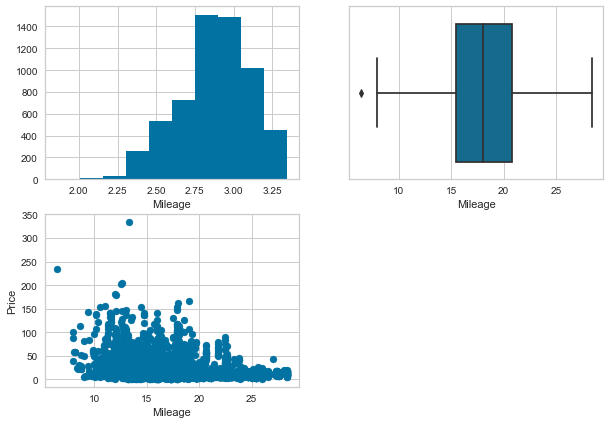

In [34]:
fig = plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
plt.hist(np.log(df['Mileage']))
plt.xlabel('Mileage')
plt.subplot(2,2,2)
sns.boxplot(x='Mileage' , data=df)
plt.subplot(2,2,3)
plt.scatter(y=df['Price'] ,x= df['Mileage'] )
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.show()

<font size = 4>Seats</font>

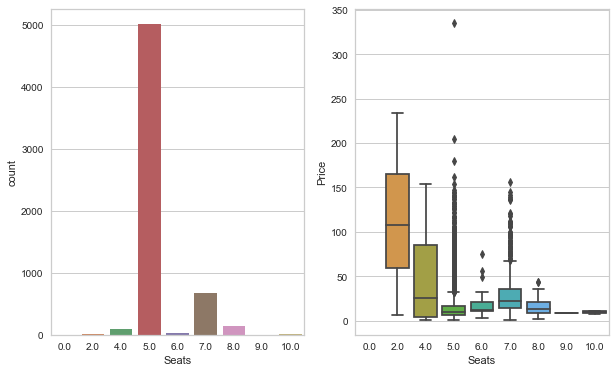

In [35]:
fig = plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.countplot(x = df['Seats'] , palette='deep')
plt.subplot(1,2,2)
sns.boxplot(y=df['Price'] ,x= df['Seats'] )
plt.show()

Handling null values

In [36]:
imp = SimpleImputer(strategy='most_frequent')
imp.fit(df[['Seats']])
x = imp.transform(df[['Seats']])
df['Seats'] = pd.DataFrame(x , index=None)
df['Seats'].isnull().sum()

0

<font size=4>Owner Type</font>

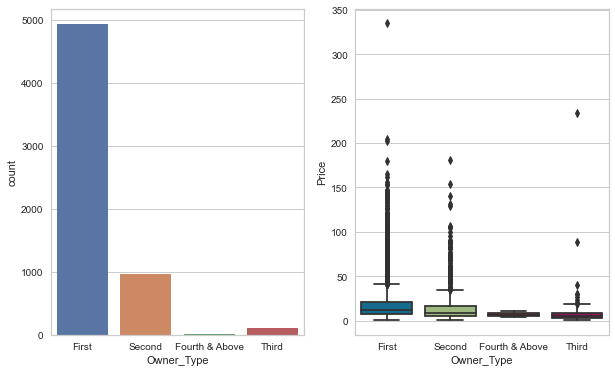

In [37]:
fig = plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.countplot(x = df['Owner_Type'] , palette='deep')
plt.subplot(1,2,2)
sns.boxplot(y=df['Price'] ,x= df['Owner_Type'] )
plt.show()

Changing owner type to numberical category

In [38]:
df['Company'].value_counts()

Maruti           1211
Hyundai          1107
Honda             608
Toyota            411
Mercedes-Benz     318
Volkswagen        315
Ford              300
Mahindra          272
BMW               267
Audi              236
Tata              186
Skoda             173
Renault           145
Chevrolet         121
Nissan             91
Land               60
Jaguar             40
Fiat               28
Mitsubishi         27
Mini               26
Volvo              21
Porsche            18
Jeep               15
Datsun             13
Force               3
ISUZU               2
Ambassador          1
Bentley             1
Isuzu               1
Smart               1
Lamborghini         1
Name: Company, dtype: int64

<font size=4>Price</font>

In [39]:
df['Price'].describe()

count    4809.000000
mean       19.104096
std        22.794947
min         0.860000
25%         6.900000
50%        11.320000
75%        19.940000
max       334.560000
Name: Price, dtype: float64

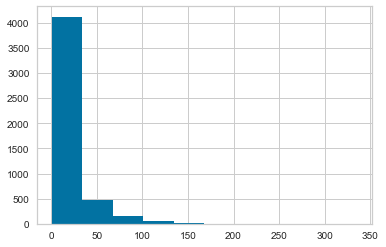

In [40]:
plt.hist(df['Price'])
plt.show()

Changing the data types

In [41]:
df.dtypes

id                     int64
Year                   int64
Kilometers_Driven      int64
Location              object
Fuel_Type             object
Transmission          object
Engine               float64
Power                float64
Mileage              float64
Seats                float64
Owner_Type            object
Price                float64
Company               object
Model                 object
dtype: object

In [42]:
df = df.astype({'Location':'category',
               'Fuel_Type':'category',
               'Transmission':'category',
               'Seats':'category',
               'Owner_Type':'category',
               'Company':'category',
               'Model':'category'})

Splitting the data back into train and test sets

In [43]:
test_final = df.loc[df['Price'].isnull()]
test_final = test_final.drop('Price' , axis=1)
print(test_final.shape)
test_final.head()

(1210, 13)


,id,Year,Kilometers_Driven,Location,Fuel_Type,Transmission,Engine,Power,Mileage,Seats,Owner_Type,Company,Model
0,100001,2014,79021,Pune,Diesel,Manual,1582.0,126.32,22.32,5.0,Second,Hyundai,i20 1.4 CRDi Sportz
1,100002,2013,46824,Coimbatore,Petrol,Manual,1086.0,68.05,19.81,5.0,Second,Maruti,Alto K10 VXI
2,100003,2016,60485,Coimbatore,Diesel,Automatic,1198.0,73.90,16.47,5.0,First,Porsche,Cayenne Diesel
3,100004,2015,40008,Kolkata,Diesel,Manual,998.0,67.10,18.90,5.0,First,Nissan,Terrano XL Plus 85 PS
4,100005,2011,87040,Chennai,Petrol,Manual,1197.0,85.80,18.50,5.0,First,Maruti,SX4 Zxi with Leather BSIII


In [44]:
train_final = df.loc[df['Price'].notnull()]
print(train_final.shape)
train_final.head()

(4809, 14)


,id,Year,Kilometers_Driven,Location,Fuel_Type,Transmission,Engine,Power,Mileage,Seats,Owner_Type,Price,Company,Model
0,1,2017,65593,Ahmedabad,Diesel,Manual,1582.0,126.32,22.32,5.0,First,12.77,Hyundai,Verna 1.6 SX
1,2,2012,66095,Ahmedabad,Petrol,Manual,1086.0,68.05,19.81,5.0,Second,5.09,Hyundai,i10 Era
2,3,2017,64961,Jaipur,Petrol,Manual,1198.0,73.90,16.47,5.0,Second,10.05,Volkswagen,Polo Petrol Comfortline 1.2L
3,4,2009,55361,Ahmedabad,Petrol,Manual,998.0,67.10,18.90,5.0,Second,3.76,Maruti,Wagon R LXI
4,5,2017,58294,Mumbai,Petrol,Manual,1197.0,85.80,18.50,5.0,First,7.26,Maruti,Ritz ZXi


# Fitting the Model

In [45]:
mod1 = smf.ols('Price~Year+Kilometers_Driven+Location+Fuel_Type+Transmission+Engine+Power+Mileage+Seats+Owner_Type+Company+Model',
              data = train_final)
reg1 = mod1.fit()
prd1 = reg1.predict()
res1 = reg1.resid
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     45.77
Date:                Sat, 24 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:58:39   Log-Likelihood:                -14034.
No. Observations:                4809   AIC:                         3.146e+04
Df Residuals:                    3114   BIC:                         4.244e+04
Df Model:                        1694                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        -1893.2462     91.183    -20.763      0.000   -2072.032   -1714.461
Location[T.Bangalore]                                                3.8339      0.654      5.863      0.000       2.552       5.116
Location[T.Chennai]                                                  0.5482      0.629      0.872      0.383      -0.684       1.781
Location[T.Coimbatore]                                               3.7411      0.587      6.378      0.000       2.591       4.891
Location[T.Delhi]                                                   -1.5391      0.602     -2.558      0.011      -2.719      -0.359
Location[T.Hyderabad]                                                1.8733      0.589      3.180      0.001       0.718       3.028
Location[T.Jaipur]                                                   0.1484      0.641      0.232      0.817      -1.108       1.405
Location[T.Kochi]                                                    0.6289      0.594      1.059      0.290      -0.536       1.794
Location[T.Kolkata]                                                 -1.5713      0.610     -2.574      0.010      -2.768      -0.374
Location[T.Mumbai]                                                  -0.4119      0.584     -0.706      0.480      -1.557       0.733
Location[T.Pune]                                                     0.0502      0.602      0.083      0.934      -1.130       1.230
Fuel_Type[T.Diesel]                                                -92.1009      4.957    -18.580      0.000    -101.820     -82.381
Fuel_Type[T.Electric]                                              -43.7752      5.932     -7.379      0.000     -55.406     -32.144
Fuel_Type[T.LPG]                                                   -82.3919      4.153    -19.838      0.000     -90.535     -74.249
Fuel_Type[T.Petrol]                                                -96.4513      5.057    -19.074      0.000    -106.366     -86.536
Transmission[T.Manual]                                             -12.5941      3.147     -4.002      0.000     -18.764      -6.424
Seats[T.4.0]                                                      -150.4897     11.245    -13.383      0.000    -172.538    -128.441
Seats[T.5.0]                                                      -152.9258      9.557    -16.001      0.000    -171.665    -134.187
Seats[T.6.0]                                                      -139.4557      7.786    -17.912      0.000    -154.721    -124.190
Seats[T.7.0]                                                      -141.6961      6.033    -23.486      0.000    -153.526    -129.867
Seats[T.8.0]            

Checking the assumptions<br>
1. Linearity <br>
2. Constant Variance <br>
3. Normality
4. Multicollinearity

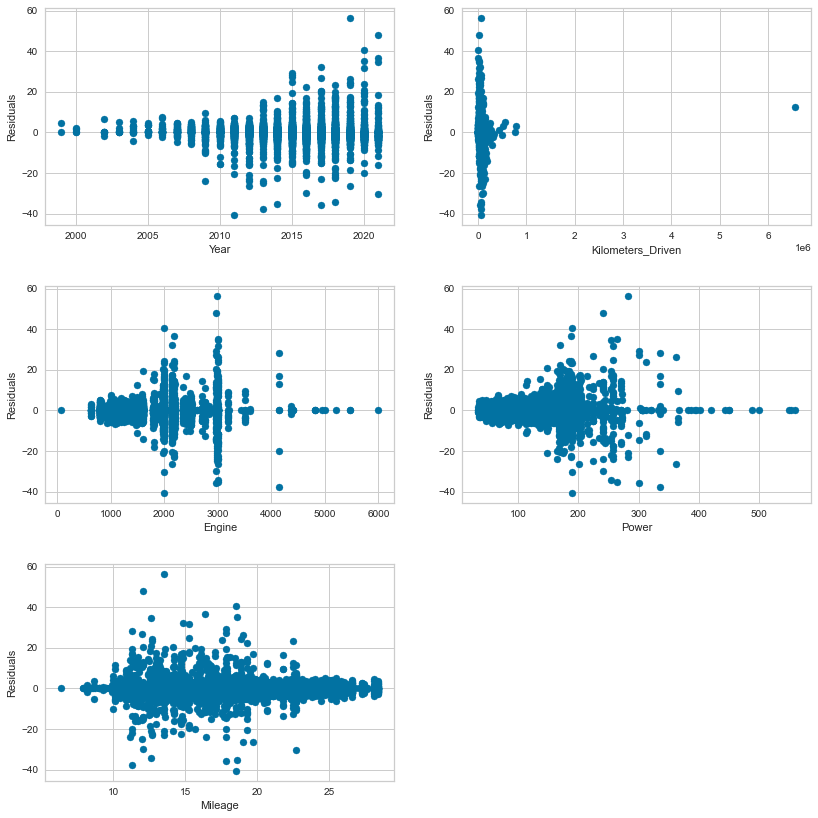

In [46]:
#1
x = ['Year' , 'Kilometers_Driven' , 'Engine' , 'Power' , 'Mileage']
fig = plt.figure(figsize=(12,12))
for i in range(0,len(x)):
    plt.subplot(3,2,i+1)
    plt.scatter(train_final[x[i]] , res1)
    plt.xlabel(x[i])
    plt.ylabel('Residuals')
fig.tight_layout(pad=3.0)

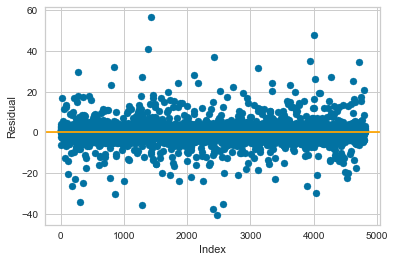

In [47]:
#2
plt.scatter(res1.index , res1)
plt.axhline(y=0 , color='Orange')
plt.xlabel('Index')
plt.ylabel('Residual')
plt.show()

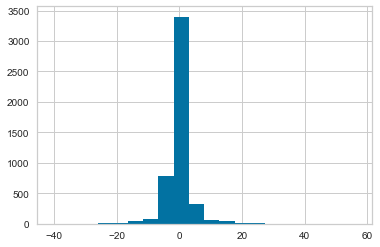

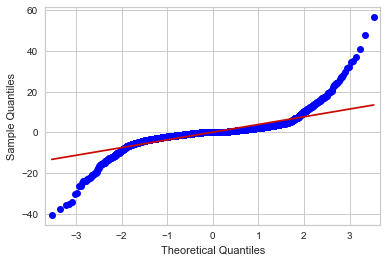

In [48]:
#3
plt.hist(res1 , bins=20)
sm.qqplot(res1 , line='r')
plt.show()

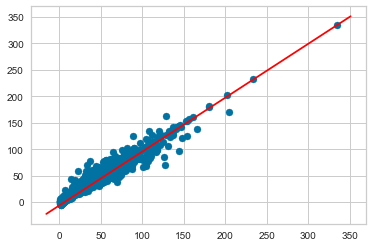

In [49]:
plt.scatter(train_final['Price'] , prd1)
x = plt.xlim()
y = plt.ylim()
plt.plot(x ,y ,color='red')

                         id      Year  Kilometers_Driven    Engine     Power  \
id                 1.000000  0.007672           0.013728  0.001225  0.009047   
Year               0.007672  1.000000          -0.143190 -0.049039  0.023379   
Kilometers_Driven  0.013728 -0.143190           1.000000  0.082897  0.030829   
Engine             0.001225 -0.049039           0.082897  1.000000  0.866669   
Power              0.009047  0.023379           0.030829  0.866669  1.000000   
Mileage           -0.000912  0.275102          -0.056656 -0.634831 -0.540919   
Price              0.013338  0.276564          -0.003075  0.659815  0.766047   

                    Mileage     Price  
id                -0.000912  0.013338  
Year               0.275102  0.276564  
Kilometers_Driven -0.056656 -0.003075  
Engine            -0.634831  0.659815  
Power             -0.540919  0.766047  
Mileage            1.000000 -0.327222  
Price             -0.327222  1.000000  


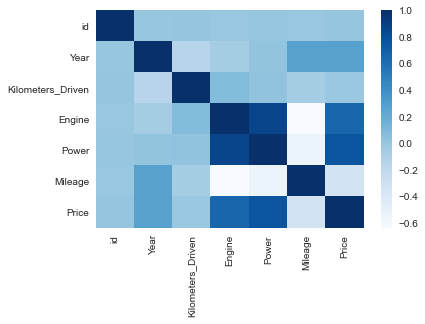

In [50]:
#4
corr = train_final.corr()
print(corr)
sns.heatmap(corr , cmap='Blues')
plt.show()

Engine and Power seem highly correlated.

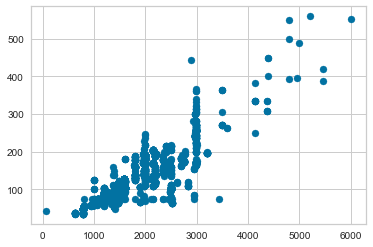

In [51]:
plt.scatter(train_final['Engine'] , train_final['Power'])
plt.show()

The scatter plot shows a linear realtionship between the two variables. Also , Power does not seem significant from the summary of the first model.Hence , dropping power.<br>
Rest all of the assumptions are satisfied . 

Checking for outliers

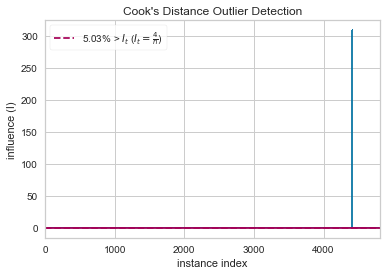

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [52]:
a = train_final[['Year' , 'Kilometers_Driven' , 'Engine' , 'Mileage']].astype(float)
b = train_final['Price']
visualiser = CooksDistance()
visualiser.fit(a,b)
visualiser.show()

In [53]:
np.where(visualiser.distance_>0.1)

(array([1403, 4402, 4488], dtype=int64),)

In [54]:
train_final = train_final.drop([1403, 4402, 4488] , axis=0)

# Model 2

In [55]:
mod2 = smf.ols('Price~Year+Kilometers_Driven+Location+Fuel_Type+Transmission+Engine+Mileage+Seats+Owner_Type+Company+Model',
              data = train_final)
reg2 = mod2.fit()
prd2 = reg2.predict()
res2 = reg2.resid
reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     44.06
Date:                Sat, 24 Jul 2021   Prob (F-statistic):               0.00
Time:                        18:58:50   Log-Likelihood:                -13963.
No. Observations:                4806   AIC:                         3.131e+04
Df Residuals:                    3114   BIC:                         4.227e+04
Df Model:                        1691                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        -1707.9343     89.215    -19.144      0.000   -1882.860   -1533.009
Location[T.Bangalore]                                                3.8423      0.645      5.955      0.000       2.577       5.107
Location[T.Chennai]                                                  1.0072      0.622      1.618      0.106      -0.213       2.227
Location[T.Coimbatore]                                               3.8655      0.579      6.677      0.000       2.730       5.001
Location[T.Delhi]                                                   -1.5165      0.594     -2.554      0.011      -2.681      -0.352
Location[T.Hyderabad]                                                2.1818      0.582      3.747      0.000       1.040       3.324
Location[T.Jaipur]                                                   0.5208      0.634      0.822      0.411      -0.721       1.763
Location[T.Kochi]                                                    0.6364      0.586      1.086      0.278      -0.513       1.786
Location[T.Kolkata]                                                 -1.9257      0.604     -3.190      0.001      -3.109      -0.742
Location[T.Mumbai]                                                  -0.6130      0.576     -1.063      0.288      -1.743       0.517
Location[T.Pune]                                                     0.3543      0.595      0.596      0.551      -0.812       1.521
Fuel_Type[T.Diesel]                                                -82.8485      4.900    -16.910      0.000     -92.455     -73.242
Fuel_Type[T.Electric]                                              -40.7074      5.562     -7.319      0.000     -51.612     -29.803
Fuel_Type[T.LPG]                                                   -75.5516      4.145    -18.228      0.000     -83.678     -67.425
Fuel_Type[T.Petrol]                                                -86.5172      4.694    -18.431      0.000     -95.721     -77.313
Transmission[T.Manual]                                             -14.2473      1.564     -9.109      0.000     -17.314     -11.180
Seats[T.4.0]                                                      -147.0232      8.264    -17.792      0.000    -163.226    -130.821
Seats[T.5.0]                                                      -147.3608      7.670    -19.212      0.000    -162.400    -132.322
Seats[T.6.0]                                                      -133.0616      6.321    -21.050      0.000    -145.456    -120.667
Seats[T.7.0]                                                      -132.3814      5.894    -22.461      0.000    -143.938    -120.825
Seats[T.8.0]            

The adj R^2 did not change significantly . Taking this as the final model.<br>

In [56]:
#Root Mean Squared Error
mse = mean_squared_error(train_final['Price'] , prd2)
rmse = np.sqrt(mse)
rmse

4.420794815573902

Making the prediction on the test data and creating a submission file

In [57]:
prd = reg2.predict(test_final)

In [58]:
sub = pd.DataFrame()
sub['id'] = test_final['id']
sub['price'] = prd
sub

,id,price
0,100001,5.290215
1,100002,3.943237
2,100003,84.350456
3,100004,10.024029
4,100005,-2.990033
...,...,...
1205,101206,2.608884
1206,101207,23.227131
1207,101208,8.963300
1208,101209,16.411606


In [59]:
sub.to_csv("D:/IPBA/Statistical Modelling/Linear Regression/Kaggle Comp/Submission.csv" , index=None)